<a href="https://colab.research.google.com/github/kap2fox/Data_driven_education/blob/main/eng_Robot_navigation_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot motion to a point
Import of neccesary libraries.

In [1]:
import numpy as np                                  # library used for working with arrays
import matplotlib.pyplot as plt                     # library for creating visualizations
from scipy.integrate import odeint                  # sub-package for an ordinary differential equation integrator
import math as m                                    # access to the mathematical functions defined by the C standard

Setting parameters and a time.

In [2]:
T_m = 0.08                                          # electromechanical time constant
k_e = 0.5                                           # constructive constant of the motor
n = 15001                                           # number of simulation steps
t = np.linspace(0,15,n)                             # setting of time space
B = 0.15                                            # base distance of the robot
r = 0.026                                           # wheel radius

DC modern model description according to the system of differential equations:

$$
\left\{
    \begin{array}\\
        \dot\omega=\frac{U}{T_m k_e}-\frac{\omega}{T_m}, \\
        \dot\theta=\omega.
    \end{array} \tag{1}
\right.
$$

In [3]:
def motor(state,t,u):
    speed, angle = state                            # setting a DC motor state vector as [speed, angle]
    state_dt = [-speed/T_m + u/ (T_m * k_e), speed ]# description of the ODE system
    return state_dt

Set up of environmental variables.

In [16]:
state_l = [0 , 0]                                   # state of the left motor
state_r = [0 , 0]                                   # state of the right motor
control_l = np.zeros(n)                             # control signal array for the left motor
control_r = np.zeros(n)                             # control signal array for the right motor
theta_l = np.zeros(n)                               # left motor rotation angle
theta_r = np.zeros(n)                               # right motor rotation angle
x = np.zeros(n)                                     # X coordinates
y = np.zeros(n)                                     # Y coordinates
path = np.zeros(n)                                  # calculated path
course = np.zeros(n)                                # course angle array
distance = np.zeros(n)                              # distance to the point
bearing = np.zeros(n)                               # robot bearing angle array
courseAngle = np.zeros(n)                           # массив курсовых углов
X_ref = -1                                          # X coordinate of the point
Y_ref = -1                                          # Y coordinate of the point
distance [0] = m.sqrt((X_ref)**2+(Y_ref)**2)        # distance to the point
bearing [0] = m.atan2(Y_ref,X_ref)                  # bearing angle

The basic mathematical description of the differential drive robot is:

$$
\left\{
    \begin{array}\\
        x = x + \Delta path \, \cos(course), \\
        y = y + \Delta path \, \sin(course), \\
        \psi = (\theta_r-\theta_l)\frac{r}{B}.
    \end{array}
\right. \tag{2}
$$

In the polar coordinates robot description with linear velocity $v$ and angular velocity $\omega$

$$
\left\{
    \begin{array}\\
        \dot{distance} = - v \cos(courseAngle), \\
        \dot{courseAngle} = - \omega + v\cfrac{\sin(courseAngle)}{distance}, \\
        courseAngle = bearing - course.
    \end{array}
\right. \tag{3}
$$

Lyapunov equation for the differential drive mobile robot $V=\cfrac{1}{2}{distance}^2+\cfrac{1}{2}{courseAngle}^2$ and it's derivative $\dot{V}=- v \cos(courseAngle)\,distance + courseAngle (- \omega + v\cfrac{\sin(courseAngle)}{distance})$. To make a derivative of Lyapunov equation not positive linear and angular velosities can be set as:

$$
\left\{
    \begin{array}\\
        v = v_{max} \cdot \cos(courseAngle)\cdot distance, \\
        \omega = \omega_{max}\cdot courseAngle + v_{max}\cdot\cos(courseAngle)\sin(courseAngle), \\
    \end{array}
\right. \tag{4}
$$

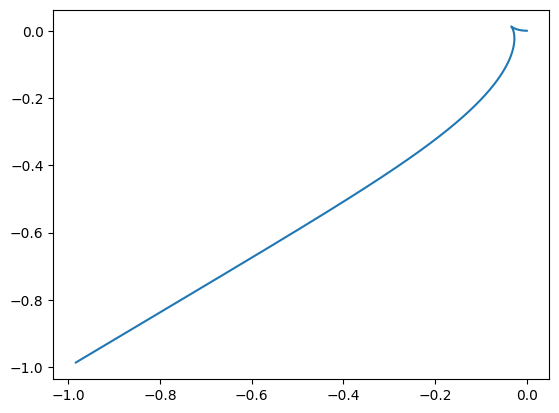

In [17]:
for i in range(1,n):

    path[i] = (theta_r[i-1] + theta_l[i-1]) * r / 2                             # calculation of the distance traveled
    course[i] = (theta_r[i-1] - theta_l[i-1]) * r / B                           # calculation of the robot's rotation angle
    x[i] = x[i-1] + (path[i]-path[i-1]) * m.cos(course[i])                      # X coordinate computation
    y[i] = y[i-1] + (path[i]-path[i-1]) * m.sin(course[i])                      # Y coordinate computation
    distance [i] = m.sqrt((X_ref - x[i])**2+(Y_ref - y[i])**2)                  # distance to the goal
    bearing [i] = m.atan2(Y_ref - y[i],X_ref - x[i])                            # bearing angle
    courseAngle [i] = bearing [i] - course [i]                                  # releative heading angle
    if courseAngle[i] > np.pi:
            courseAngle[i] = courseAngle[i] - 2 * np.pi
    if courseAngle[i] < -np.pi:
            courseAngle[i] = courseAngle[i] + 2 * np.pi                         # bringing the heading angle to the range [-pi, pi]

    control_l [i] = 6 * np.cos (courseAngle [i]) * np.tanh(distance [i]) - 2 * (courseAngle [i]) # nonlinear control signal according Lyapunov function
    control_r [i] = 6 * np.cos (courseAngle [i]) * np.tanh(distance [i]) + 2 * (courseAngle [i]) # nonlinear control signal according Lyapunov function
    #control_l [i] = 4 * distance [i] - 4 * courseAngle [i]                      # proportional controller
    #control_r [i] = 4 * distance [i] + 4 * courseAngle [i]                      # proportional controller
    if control_l[i] > 8:
            control_l[i] = 8
    if control_l[i] < -8:
            control_l[i] = -8
    if control_r[i] > 8:
            control_r[i] = 8
    if control_r[i] < -8:
            control_r[i] = -8                                                   # limitation of the control signal

    motor_l = odeint(motor, state_l,[t[i-1],t[i]],args=(control_l [i],))        # ODE solution for the left motor
    state_l = motor_l[1,:]                                                      # getting a state of the left motor
    theta_l[i] = motor_l[1,1]                                                   # left motor rotation
    motor_r = odeint(motor, state_r,[t[i-1],t[i]],args=(control_r [i],))        # ODE solution for the right motor
    state_r = motor_r[1,:]                                                      # getting a state of the right motor
    theta_r[i] = motor_r[1,1]                                                   # right motor rotation

plt.plot(x, y)